# Procesamiento de los datos

## Carga de dataset preprocesado mediante consultas SQL dentro de bigquery

Importa **librerías** clave para:
+ Manipular datos (pandas).
+ Conectarse a BigQuery y leer datos (google.cloud.bigquery).
+ Entrenar modelos de ML (sklearn, xgboost).
+ Evaluar resultados (accuracy_score, classification_report).
+ Visualizar datos (matplotlib).

Se define una **función** traer_datos() que:
+ Se conecta a Google BigQuery.
+ Ejecuta una consulta SQL para extraer datos de la tabla antel-equipo4.desafio_antel.sesiones_agregadas.
+ Convierte los resultados en un DataFrame de pandas para su análisis.

In [2]:
import pandas as pd
from google.cloud import bigquery
from google.cloud.bigquery_storage import BigQueryReadClient
from sklearn.model_selection import train_test_split 
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import PartialDependenceDisplay

def traer_datos():
    client = bigquery.Client()
    bqstorage_client = BigQueryReadClient()
    query = """
    SELECT *
    FROM `antel-equipo4.desafio_antel.sesiones_agregadas`
    """
    df = client.query(query).to_dataframe(bqstorage_client=bqstorage_client)
    return df

## Conversión de las variables categóricas en valores númericos para poder llevar a cabo el modelo de machine learning
Para ejecutar el modelo de machine learning todas las variables deben ser númericas por lo que las variables horario del día y plataforma usada deben ser transformadas. Como el modelo a usar no es redes neuronales, no es necesario normalizar las variables.


In [3]:
def variables_categoricas_procesamiento(df):
    columnas_cat = ['horario_del_dia', 'plataforma_usada']
    for col in columnas_cat:
        df[col] = df[col].astype('category').cat.codes
    return df

## Definición de la función para la matriz de correlación
Se ejecuta matriz de correlación para realizar un análisis de las variables por separado, y poder realizar recomendaciones en base a las correlaciones de las variables, por ejemplo si el horario del día está muy correlacionado con el play, recomendar el uso de ads en ciertos horarios específicos.

In [4]:
def obtener_matriz_correlacion(df):
    df_correlacion = df.drop(columns=['session_id'])
    matriz_correlacion = df_correlacion.corr()
    return matriz_correlacion

## División datos en train, validation, y test
Se divide el dataset en 60,20 y 20, no se evalúa la posibilidad de realizar validacion cruzada debido a que el dataset es muy grande y es mas confiable dividir los datos de esta manera para no tener sobreajuste. 

In [5]:
def division_datos(df):
    df_sesiones = df.dropna(subset=['play'])
    X = df_sesiones.drop('play', axis=1)  
    y = df_sesiones['play']  
    
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

    # Se tiene 60% train, 20% val, 20% test
    # Sacamos la columna de session id porque no sirve para predecir
    X_train = X_train.drop(columns=["session_id"])
    X_test = X_test.drop(columns=["session_id"])
    X_val = X_val.drop(columns=["session_id"])
    return X_train, X_val, X_test, y_train, y_val, y_test


# Definición de modelos de predicción a utilizar

A continuación se definen diferentes modelos que fueron utilizados para la predicción. Ambos sirven para evaluar la importancia de las features consideradas. 

## Gradient boosting

In [6]:
def xgboost(X_train, X_val, X_test, y_train, y_val, y_test):
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        max_depth=6,
        learning_rate=0.05,
        n_estimators=100,
        random_state=42
    )

    model.fit(X_train, y_train,eval_set=[(X_val, y_val)])

    y_pred = model.predict(X_test)

    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    importancia_variables(X_train, model)
    
    disp = PartialDependenceDisplay.from_estimator(
        model,
        X_train,
        ['eventos_unicos_sesion'],
        kind='average'
    )
    disp.figure_.set_size_inches(10, 6)
    disp.figure_.suptitle('Partial Dependence Plot para eventos unicos por sesion', y=1.02)

    disp.figure_.savefig("eventos_unicos_sesion_dependence.png", bbox_inches='tight')
    return model

## RandomForest

In [7]:
def random_forest(X_train, X_val, X_test, y_train, y_val, y_test):
    model = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    
def cross_validation(X_train, X_val, X_test, y_train, y_val, y_test):
    param_grid = {
        'max_depth': [4, 6, 8],
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1]
    }

    grid = GridSearchCV(
        estimator=xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss'),
        param_grid=param_grid,
        scoring='f1',
        cv=3,
        n_jobs=-1
    )

    grid.fit(X_train, y_train)
    print("Mejores hiperparámetros:", grid.best_params_)
    print("Mejor F1:", grid.best_score_)
    return model
    

# Análisis de los resultados

## Definición de una función para conocer la importancia de las features
Resulta de gran importancia conocer la **importancia** de las features que toma el modelo para poder darle mayor protagonismo a las features mas importantes a la hora del análisis de datos. De todos modos, en este caso las features más importantes no tienen tanto valor para esto ya que consisten en la cantidad de eventos que tiene cada sesión.

In [8]:
def importancia_variables(X_train, model):
    importancias = pd.DataFrame({
        'feature': X_train.columns,
        'importance': model.feature_importances_
    }).sort_values(by='importance', ascending=False)

    print(importancias)

## Muestra los resultados del entrenamiento del modelo y lo guarda
En este notebook se ejecuta el modelo y se devuelve la matriz de correlación y los resultados de accuracy y otras métricas. También guarda el modelo en formato **joblib** para poder luego ser descargado por ANTEL para próximos usos del modelo.
Las correlaciones obtenidas con la columna play son las siguientes:
eventos_unicos_sesion	0.758	Muy fuerte correlación positiva.

screen_view_count	0.337	Correlación positiva moderada.

user_engagement_count	0.244	Correlación positiva débil.

plataforma_usada	0.116	Correlación positiva muy débil.

total_eventos_sesion	0.262	Correlación positiva débil.

tuvo_view_item	0.088	Prácticamente nula (pero positiva).

primera_hora	0.030	Prácticamente nula.

duracion_sesion_segundos	0.003	Sin relación.

horario_del_dia	-0.051	Correlación negativa muy débil.

A grandes rasgos lo que sugiere esta informacion es que cuanto más tiempo esta el usuario en la app, más chances tiene de dar play a algún item. También hay una correlacion considerable entre el play y la plataforma usada, lo que puede significar que la interfaz para una plataforma es mas amigable que la otra. Tambien se puede deber simplemente a una tendencia social en la cual los usuarios de android tienden a usar mas la app que los de ios. La correlacion entre el horario del dia tambien es considerable y se puede interpretar que en los horarios nocturnos la gente tiende a usar menos la app.  


Matriz correlacion:                              screen_view_count  tuvo_view_item      play  \
screen_view_count                     1.000000        0.235661  0.337079   
tuvo_view_item                        0.235661        1.000000  0.087800   
play                                  0.337079        0.087800  1.000000   
user_engagement_count                 0.546775        0.089839  0.243645   
primera_hora                          0.106503        0.038271  0.030458   
horario_del_dia                       0.057737        0.055992 -0.051291   
plataforma_usada                      0.039382       -0.040846  0.116257   
duracion_sesion_segundos              0.012241        0.005955  0.002697   
total_eventos_sesion                  0.769814        0.153663  0.261979   
eventos_unicos_sesion                 0.393020        0.418525  0.758446   
engaged_session_event_count                NaN             NaN       NaN   
hubo_compra                                NaN             NaN      

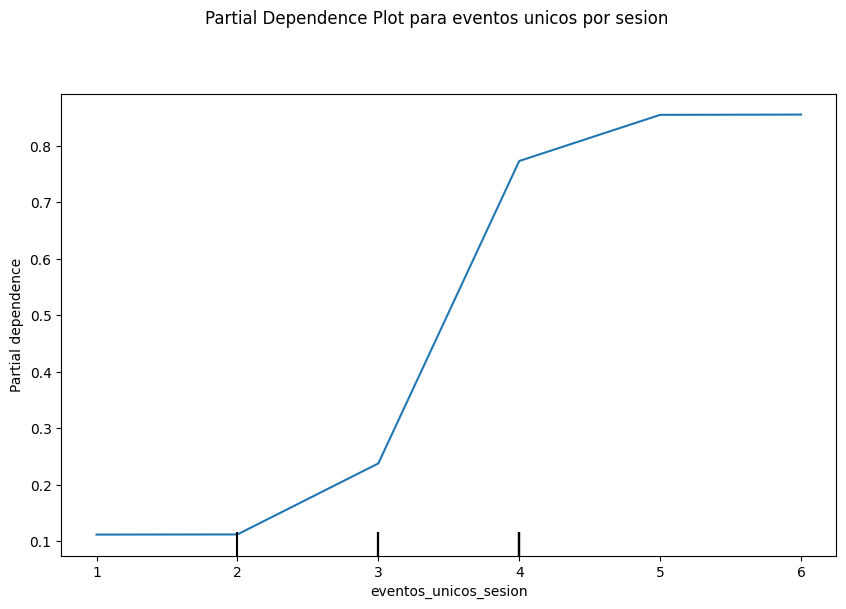

In [12]:
import joblib
from joblib import dump, load
def main():
    df = traer_datos()
    #print(f"Cantidad de filas: {len(df)}")
    df_procesado = variables_categoricas_procesamiento(df)
    matriz_correlacion = obtener_matriz_correlacion(df_procesado)
    print(f"Matriz correlacion: {matriz_correlacion}")
    print(matriz_correlacion.to_string())
    X_train, X_val, X_test, y_train, y_val, y_test = division_datos(df_procesado)
    print("Modelo xgboost")
    model = xgboost(X_train, X_val, X_test, y_train, y_val, y_test)
    print("Modelo random forest")
    random_forest(X_train, X_val, X_test, y_train, y_val, y_test)
    print("Cross validation xgboost")
    #cross_validation(X_train, X_val, X_test, y_train, y_val, y_test)
    joblib.dump(model, 'modelo_entrenado.joblib')
if __name__=="__main__":
    main()

# Cargar el modelo pronto para usarlo

In [ ]:
model = joblib.load(modelo_entrenado.joblib)